# Using a csv dataset provided by the Hass Avocado Board, create a machine learning model to predict the best location in the United States for a retail store to sell a new avocado product. 

In [2]:
# Import dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import*
from sklearn.preprocessing import*
from sklearn.ensemble import*
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree
from flask import Flask
from flask import render_template
import psycopg2

## Connecting to AWS Database

In [3]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.1'
spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [4]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-01-29 00:20:00--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.09s   

2021-01-29 00:20:01 (11.2 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [6]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://tanianguyenavocado-bucket.s3.amazonaws.com/avocado-updated-2020.csv"
spark.sparkContext.addFile(url)
avocado_data_df = spark.read.csv(SparkFiles.get("avocado-updated-2020.csv"), sep=",", header=True, inferSchema=True)

In [7]:
# Show DataFrame
avocado_data_df.show()

+--------+-------------+------------+----------+----------+---------+----------+----------+----------+-----------+------------+----+--------------------+
|    date|average_price|total_volume|      4046|      4225|     4770|total_bags|small_bags|large_bags|xlarge_bags|        type|year|           geography|
+--------+-------------+------------+----------+----------+---------+----------+----------+----------+-----------+------------+----+--------------------+
|1/4/2015|         1.22|    40873.28|    2819.5|  28287.42|     49.9|   9716.46|   9186.93|    529.53|        0.0|conventional|2015|              Albany|
|1/4/2015|         1.79|     1373.95|     57.42|    153.88|      0.0|   1162.65|   1162.65|       0.0|        0.0|     organic|2015|              Albany|
|1/4/2015|          1.0|   435021.49| 364302.39|  23821.16|    82.15|  46815.79|  16707.15|  30108.64|        0.0|conventional|2015|             Atlanta|
|1/4/2015|         1.76|     3846.69|   1500.15|    938.35|      0.0|   1408

## Explore the data and clean 

In [ ]:
#read the dataset
data = 'avocado-updated-2020.csv'
#df = pd.read_csv(data, index_col = 'geography')
df = pd.read_csv(data)
df.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,1/4/2015,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,1/4/2015,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,1/4/2015,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,1/4/2015,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,1/4/2015,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30021 entries, 0 to 30020
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30021 non-null  object 
 1   average_price  30021 non-null  float64
 2   total_volume   30021 non-null  float64
 3   4046           30021 non-null  float64
 4   4225           30021 non-null  float64
 5   4770           30021 non-null  float64
 6   total_bags     30021 non-null  float64
 7   small_bags     30021 non-null  float64
 8   large_bags     30021 non-null  float64
 9   xlarge_bags    30021 non-null  float64
 10  type           30021 non-null  object 
 11  year           30021 non-null  int64  
 12  geography      30021 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 3.0+ MB


In [ ]:
df.isnull().sum()

date             0
average_price    0
total_volume     0
4046             0
4225             0
4770             0
total_bags       0
small_bags       0
large_bags       0
xlarge_bags      0
type             0
year             0
geography        0
dtype: int64

In [ ]:
# Determine the dytpes of each column 
df.dtypes

date              object
average_price    float64
total_volume     float64
4046             float64
4225             float64
4770             float64
total_bags       float64
small_bags       float64
large_bags       float64
xlarge_bags      float64
type              object
year               int64
geography         object
dtype: object

In [ ]:
#Determine if there is duplicated data
print('total number of duplicate values : ',sum(df.duplicated()))

total number of duplicate values :  0


### The target column for the machine learning model will be the geography column because we are trying to predict a location for the next retail store based on the sales information contained in the features columns. Determine specific information about the geography column.

In [ ]:
# Create a list of locations from the geography column and convert them all to numbers for the machine learning model
df['geography'].unique()

array(['Albany', 'Atlanta', 'Baltimore/Washington', 'Boise', 'Boston',
       'Buffalo/Rochester', 'California', 'Charlotte', 'Chicago',
       'Cincinnati/Dayton', 'Columbus', 'Dallas/Ft. Worth', 'Denver',
       'Detroit', 'Grand Rapids', 'Great Lakes', 'Harrisburg/Scranton',
       'Hartford/Springfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'Las Vegas', 'Los Angeles', 'Louisville', 'Miami/Ft. Lauderdale',
       'Midsouth', 'Nashville', 'New Orleans/Mobile', 'New York',
       'Northeast', 'Northern New England', 'Orlando', 'Philadelphia',
       'Phoenix/Tucson', 'Pittsburgh', 'Plains', 'Portland',
       'Raleigh/Greensboro', 'Richmond/Norfolk', 'Roanoke', 'Sacramento',
       'San Diego', 'San Francisco', 'Seattle', 'South Carolina',
       'South Central', 'Southeast', 'Spokane', 'St. Louis', 'Syracuse',
       'Tampa', 'Total U.S.', 'West', 'West Tex/New Mexico'], dtype=object)

In [ ]:
#Determine the distribution of the data in the geography column 
# Checking for class balance using the column I think will be the target: geography
df.groupby('geography').size() 

geography
Albany                  556
Atlanta                 556
Baltimore/Washington    556
Boise                   556
Boston                  556
Buffalo/Rochester       556
California              556
Charlotte               556
Chicago                 556
Cincinnati/Dayton       556
Columbus                556
Dallas/Ft. Worth        556
Denver                  556
Detroit                 556
Grand Rapids            556
Great Lakes             556
Harrisburg/Scranton     556
Hartford/Springfield    556
Houston                 556
Indianapolis            556
Jacksonville            556
Las Vegas               556
Los Angeles             556
Louisville              556
Miami/Ft. Lauderdale    556
Midsouth                556
Nashville               556
New Orleans/Mobile      556
New York                556
Northeast               556
Northern New England    556
Orlando                 556
Philadelphia            556
Phoenix/Tucson          556
Pittsburgh              556
Plains    

In [ ]:
# Drop the geography columns that summarize the data already found in the cities...
df.drop(df.loc[df['geography']== 'California'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Great Lakes'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Northeast'].index, inplace=True)
df.drop(df.loc[df['geography']== 'South Central'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Plains'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Northern New England'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Total U.S.'].index, inplace=True)
df.drop(df.loc[df['geography']== 'West'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Great Lakes'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Southeast'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Houston'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Tampa'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Las Vegas'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Charlotte'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Grand Rapids'].index, inplace=True)
df.drop(df.loc[df['geography']== 'Boise'].index, inplace=True)
df.head(10)

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,1/4/2015,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,1/4/2015,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,1/4/2015,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,1/4/2015,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,1/4/2015,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington
5,1/4/2015,1.29,19137.28,8040.64,6557.47,657.48,3881.69,3881.69,0.00,0.0,organic,2015,Baltimore/Washington
8,1/4/2015,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston
9,1/4/2015,1.83,2192.13,8.66,939.43,0.00,1244.04,1244.04,0.00,0.0,organic,2015,Boston
10,1/4/2015,1.40,116253.44,3267.97,55693.04,109.55,57182.88,57182.88,0.00,0.0,conventional,2015,Buffalo/Rochester
11,1/4/2015,1.73,379.82,0.00,59.82,0.00,320.00,320.00,0.00,0.0,organic,2015,Buffalo/Rochester


In [ ]:
# Determine the number of locations after the summary locations are deleted (Started with 54)
df['geography'].nunique()

39

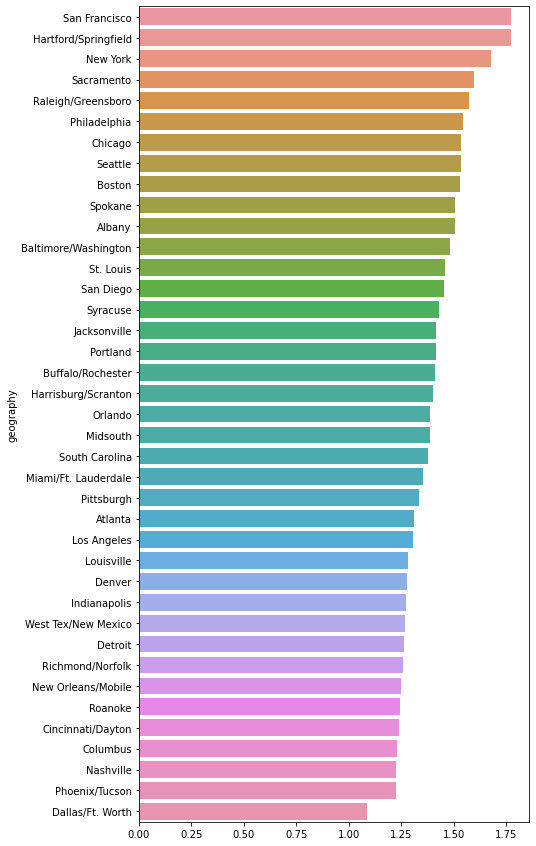

In [ ]:
# Which geographic location contains the highest average price for avocados
avg_pr=df.groupby('geography')['average_price'].mean().sort_values(ascending=False).values
loc=df.groupby('geography')['average_price'].mean().sort_values(ascending=False).index
plt.figure(figsize=(7,15))
sns.barplot(x=avg_pr,y=loc)

Text(0.5, 1.0, 'Average Pieces Sold per Area')

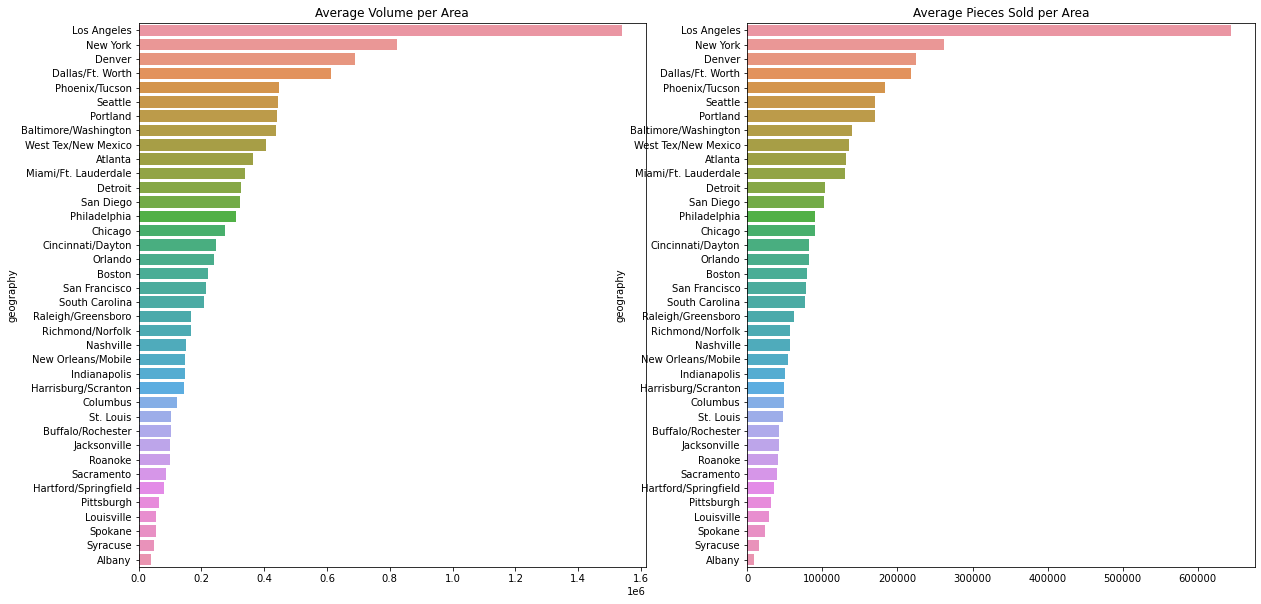

In [ ]:
# Which geographical area consumed the most avocaos
avg_vol=df.groupby('geography')['total_volume'].mean().sort_values(ascending=False).values[1:]
loc=df.groupby('geography')['total_volume'].mean().sort_values(ascending=False).index[1:]

avg_bag=df.groupby('geography')['total_bags'].mean().sort_values(ascending=False).values[1:]
loc=df.groupby('geography')['total_bags'].mean().sort_values(ascending=False).index[1:]

fig,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(x=avg_vol,y=loc,ax=ax[0])
ax[0].set_title('Average Volume per Area')

sns.barplot(x=avg_bag,y=loc,ax=ax[1])
ax[1].set_title('Average Pieces Sold per Area')

Text(0.5, 1.0, 'Organic Average Price by Month')

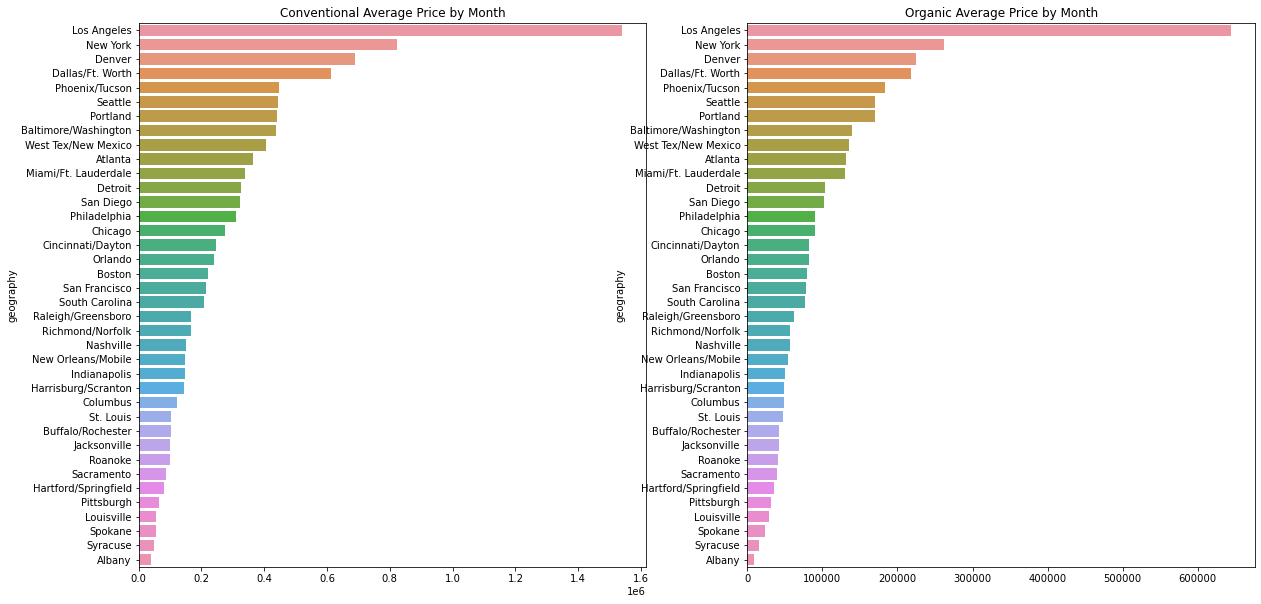

In [ ]:
# What is the average price per month in each of the geographical locations? 
average_price=df.groupby('geography')['total_volume'].mean().sort_values(ascending=False).values[1:]
loc=df.groupby('geography')['total_volume'].mean().sort_values(ascending=False).index[1:]
average_price=df.groupby('geography')['total_bags'].mean().sort_values(ascending=False).values[1:]
loc=df.groupby('geography')['total_bags'].mean().sort_values(ascending=False).index[1:]


fig,ax=plt.subplots(1,2,figsize=(20,10))
sns.barplot(x=avg_vol,y=loc,ax=ax[0])
ax[0].set_title('Conventional Average Price by Month')

sns.barplot(x=avg_bag,y=loc,ax=ax[1])
ax[1].set_title('Organic Average Price by Month')

## Encode catagorical variables of the feature columns into numeric types so they will work with the machine learning model.

In [ ]:
# Convert the date column to a timestamp for the machine learning model
df["date"] = df["date"].map(pd.to_datetime)
df["date"][0]

Timestamp('2015-01-04 00:00:00')

In [ ]:
import datetime
df["date"] = df["date"].map(lambda x: (x-datetime.datetime(1970,1,1)).total_seconds())
df["date"]

0        1.420330e+09
1        1.420330e+09
2        1.420330e+09
3        1.420330e+09
4        1.420330e+09
             ...     
30010    1.589674e+09
30011    1.589674e+09
30012    1.589674e+09
30019    1.589674e+09
30020    1.589674e+09
Name: date, Length: 21681, dtype: float64

In [ ]:
# Change the 'type' column from words to numbers for the ml model
df.type.map(dict(conventional=1, organic=0))
df = df.replace(to_replace="conventional", value="1")
df = df.replace(to_replace="organic", value="0")
df.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,1.420330e+09,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,1,2015,Albany
1,1.420330e+09,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,0,2015,Albany
2,1.420330e+09,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,1,2015,Atlanta
3,1.420330e+09,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,0,2015,Atlanta
4,1.420330e+09,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,1,2015,Baltimore/Washington


In [ ]:
#Determine the pairwise correlation of all columns in the dataframe
df.corr()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,year
date,1.000000,0.007209,0.064048,0.008159,-0.037174,-0.079336,0.191532,0.138829,0.250811,0.110910,0.983096
average_price,0.007209,1.000000,-0.367108,-0.394493,-0.236825,-0.221692,-0.320674,-0.290327,-0.289736,-0.097017,-0.018717
total_volume,0.064048,-0.367108,1.000000,0.854867,0.810187,0.583307,0.918736,0.914781,0.595513,0.432915,0.073683
4046,0.008159,-0.394493,0.854867,1.000000,0.478765,0.469403,0.746130,0.741807,0.482636,0.373831,0.017201
4225,-0.037174,-0.236825,0.810187,0.478765,1.000000,0.503169,0.617224,0.651492,0.331359,0.150045,-0.028609
4770,-0.079336,-0.221692,0.583307,0.469403,0.503169,1.000000,0.471223,0.493765,0.211007,0.414866,-0.072373
total_bags,0.191532,-0.320674,0.918736,0.746130,0.617224,0.471223,1.000000,0.960833,0.720374,0.561148,0.198858
small_bags,0.138829,-0.290327,0.914781,0.741807,0.651492,0.493765,0.960833,1.000000,0.503891,0.513035,0.145715
large_bags,0.250811,-0.289736,0.595513,0.482636,0.331359,0.211007,0.720374,0.503891,1.000000,0.353346,0.257108
xlarge_bags,0.110910,-0.097017,0.432915,0.373831,0.150045,0.414866,0.561148,0.513035,0.353346,1.000000,0.111276


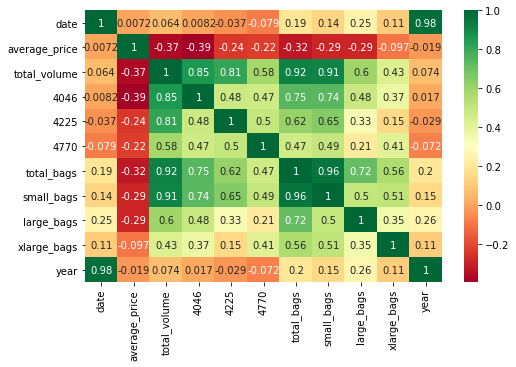

In [ ]:
#Plot the relationships in a heat map to visualize the degree of relatedness.
plt.subplots(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn")
plt.show()

 ## Preprocess the dataset

In [ ]:
#Encode the catagorical columns for use in the ml model
le = LabelEncoder()
df['geography'] = le.fit_transform(df['geography'])
df

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,1.420330e+09,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,1,2015,0
1,1.420330e+09,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.00,0,2015,0
2,1.420330e+09,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,1,2015,1
3,1.420330e+09,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.00,0,2015,1
4,1.420330e+09,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.00,1,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30010,1.589674e+09,2.02,8478.00,1536.00,1468.00,0.00,5473.00,3373.00,2100.00,0.00,0,2020,36
30011,1.589674e+09,1.31,117231.76,12121.98,47634.53,941.62,56533.63,44340.34,10544.39,1648.90,1,2020,37
30012,1.589674e+09,1.63,1798.00,249.00,143.00,0.00,1407.00,1111.00,295.00,0.00,0,2020,37
30019,1.589674e+09,0.89,1240709.05,430203.10,126497.28,21104.42,662904.25,395909.35,265177.09,1817.81,1,2020,38


In [ ]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,1.420330e+09,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,1,2015,0
1,1.420330e+09,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.00,0,2015,0
2,1.420330e+09,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,1,2015,1
3,1.420330e+09,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.00,0,2015,1
4,1.420330e+09,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.00,1,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30010,1.589674e+09,2.02,8478.00,1536.00,1468.00,0.00,5473.00,3373.00,2100.00,0.00,0,2020,36
30011,1.589674e+09,1.31,117231.76,12121.98,47634.53,941.62,56533.63,44340.34,10544.39,1648.90,1,2020,37
30012,1.589674e+09,1.63,1798.00,249.00,143.00,0.00,1407.00,1111.00,295.00,0.00,0,2020,37
30019,1.589674e+09,0.89,1240709.05,430203.10,126497.28,21104.42,662904.25,395909.35,265177.09,1817.81,1,2020,38


## Scale and split the data

In [ ]:
from sklearn.preprocessing import StandardScaler
# create an object of the StandardScaler
scaler = StandardScaler()
# fit with the Item_MRP
scaler.fit(np.array(df.geography).reshape(-1,1))
# transform the data
df.geography = scaler.transform(np.array(df.geography).reshape(-1,1))

In [ ]:
# importing libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
 # separate the independent and target variable 
X_train = df.drop(columns=['geography'])
Y_train = df['geography']

 # randomly split the data
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25,random_state=0)

# # shape of train and test splits
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((16260, 12), (5421, 12), (16260,), (5421,))

## Create two machine learning model pipelines to determine which will provide the best prediction for a U.S. location to begin the marketing trials. The models are: Linear Regression and Random Forest Regression.

## Linear Regression Model with root mean squared error

### Root mean squared error is  the measure of how well a regression line fits the data points

In [ ]:
# create an object of the LinearRegression Model
model_LR = LinearRegression()

# fit the model with the training data
model_LR.fit(x_train, y_train)

# predict the target on train and test data 
y_pred = model_LR.predict(x_train)
x_pred  = model_LR.predict(x_test)

# Root Mean Squared Error on train and test date
print('RMSE on train data: ', mean_squared_error(y_train, y_pred)**(0.5))
print('RMSE on test data: ',  mean_squared_error(y_test, x_pred)**(0.5))

RMSE on train data:  0.984303274976897
RMSE on test data:  0.995118248925634


In [ ]:
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_true, x_pred))
printnp.sqrt(metrics.mean_squared_error(y_true, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [5421, 16260]

## Random Forest Regression Model with root mean squared error

In [ ]:
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=3)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

RMSE on train data:  0.9296310002075869
RMSE on test data:  0.9388250541281964


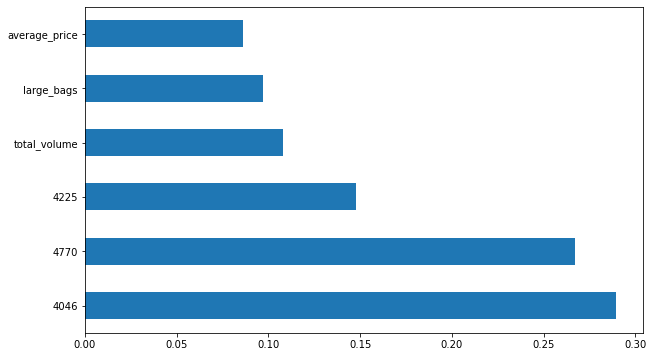

In [ ]:
# plot the 6 most important features 
plt.figure(figsize=(10,6))
feat_importances = pd.Series(model_RFR.feature_importances_, index = train_x.columns)
feat_importances.nlargest(6).plot(kind='barh');

In [ ]:
# training data with 7 most important features
train_x_if = train_x[['average_price',
                    'total_volume',
                    'large_bags',
                    '4770',
                    '4046',
                    '4225']]
# test data with 7 most important features
test_x_if = test_x[['average_price',
                    'total_volume',
                    'large_bags',
                    '4770',
                    '4046',
                    '4225']]

# create an object of the RandfomForestRegressor Model
model_RFR_with_if = RandomForestRegressor(max_depth=10,random_state=2)

# fit the model with the training data
model_RFR_with_if.fit(train_x_if, train_y)

# predict the target on the training and test data
predict_train_with_if = model_RFR_with_if.predict(train_x_if)
predict_test_with_if = model_RFR_with_if.predict(test_x_if)

# Root Mean Squared Error on the train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train_with_if)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test_with_if)**(0.5))

RMSE on train data:  0.5762940049189809
RMSE on test data:  0.6489143856262758


## Random Forest Classifier

In [ ]:
#RandomForest model 
from sklearn.ensemble import RandomForestClassifier
pm = RandomForestClassifier(random_state=0)

In [ ]:
pm.fit(X_train,y_train)
y_tr1=pm.predict(X_train)
y_pr=pm.predict(X_test)

print('train data accuracy :',pm.score(X_train,y_train))
print('test data accuracy :',pm.score(X_test,y_test))
print('loss of train data :',mean_squared_error(y_train,y_tr1))
print('loss of test data :',mean_squared_error(y_test,y_pr))

train data accuracy : 0.028198260824128796
test data accuracy : 0.020248330651116087
loss of train data : 123.07757381795476
loss of test data : 124.03668518899758
